## HandWritten digit recognition using RNN
```
 -The input images are of dimension 8*8.
 -The idea is to pass each row of pixel(8 pixels) as a timestamp to rnn thus each image will have 8 timestamps
```

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [32]:
from sklearn.datasets import load_digits

# Load the MNIST dataset
mnist = load_digits()

# Images are already flattened (8x8 image to 64 pixels)
images = mnist.data

# Create a DataFrame with image data as columns and labels as a separate column
df = pd.DataFrame(data=images, columns=[f"pixel_{i}" for i in range(64)])
df["label"] = mnist.target

df

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9


In [33]:
Y = df['label']
Y
X = df.drop('label',axis= 1)
X

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_54,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


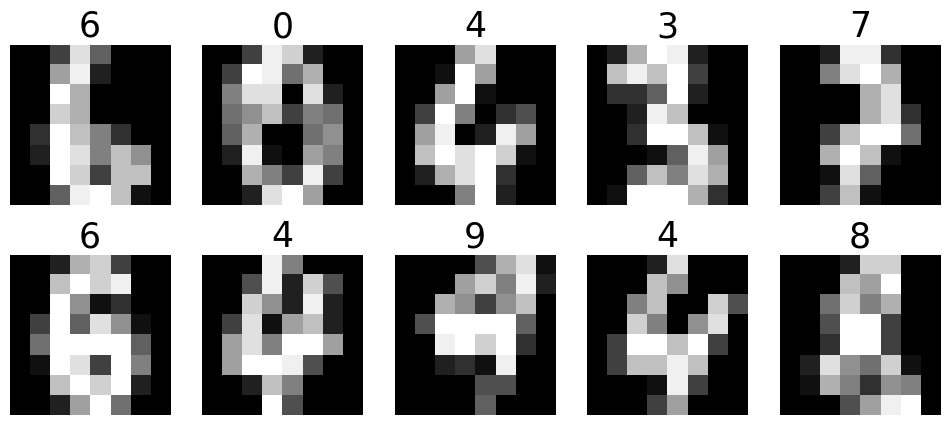

In [34]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,1797,size=10)
for i in range(10):
    axes[i].imshow(X.iloc[idx[i],:].values.reshape(8,8), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(Y[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [105]:
# Test-Train-Val Dataset Spliting.
x_t,x_test,y_t,y_test = train_test_split(X,Y,test_size = 0.2,random_state = 42)
x_train,x_val,y_train,y_val = train_test_split(x_t,y_t,test_size=0.2,random_state=42)

In [234]:
class CustomDataset(Dataset):
    def __init__(self,features,label):
        features = features.to_numpy()
        self.features = features.reshape(features.shape[0], 8, 8)   
        self.label = label
        print(self.features.shape)
    
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self,idx):
        sample = self.features[idx]
        label = self.label.values[idx]
        sample_tensor = torch.tensor(sample,dtype = torch.float32)
        label_tensor = torch.tensor(label,dtype = torch.long)

        return sample_tensor,label_tensor

In [235]:
train_dataset = CustomDataset(x_train,y_train)
val_dataset = CustomDataset(x_val,y_val)
test_dataset = CustomDataset(x_test,y_test)

(1149, 8, 8)
(288, 8, 8)
(360, 8, 8)


In [236]:
batch_size = 64
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

In [237]:
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size = batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [238]:
INPUT_SIZE=8
HIDDEN_SIZE=64
NUM_LAYER=2
OUTPUT_SIZE=10

In [271]:
class MyRNN(nn.Module):
    #STRUCTURE
    def __init__(self,input_size, hidden_size,num_layers,output_size):
        super(MyRNN,self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size,num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*8, output_size)

    #DATA FLOW
    def forward(self, x):
        out, hidden = self.rnn(x)
#         both are same:-
#         print(hidden[-1,:,:])
#         print(out[:,-1,:])
        out = out.reshape(out.shape[0], -1) # putting all hidden states recieved in out side by side to send it as input to linear unit
        out = self.fc(out)
        return out

## Parameters in RNN
-`input_size(size of one word tensor(may be embedding etc.))`: The number of expected features in the input x.

-`hidden_size(number of nodes in one layer)`: The number of features in the hidden state h. This is also the output size of the RNN layer.

-`num_layers`: Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and producing the final results.

-`nonlinearity(activation)`: The non-linearity to use. Can be either 'tanh' (default) or 'relu'. 'tanh' is the hyperbolic tangent function, and 'relu' is the rectified linear unit function.

-`bias`: If False, then the layer does not use bias weights b_ih and b_hh. Default: True.

-`batch_first(keep true as it is more convinient to work with)`: If True, then the input and output tensors are provided as (batch, seq, feature). Default: False, which means the input and output tensors are provided as (seq, batch, feature).

-`dropout`: If non-zero, introduces a dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0.

-`bidirectional`: If True, becomes a bidirectional RNN. Default: False.

## The meaning of: `out, hidden = self.rnn(x)`
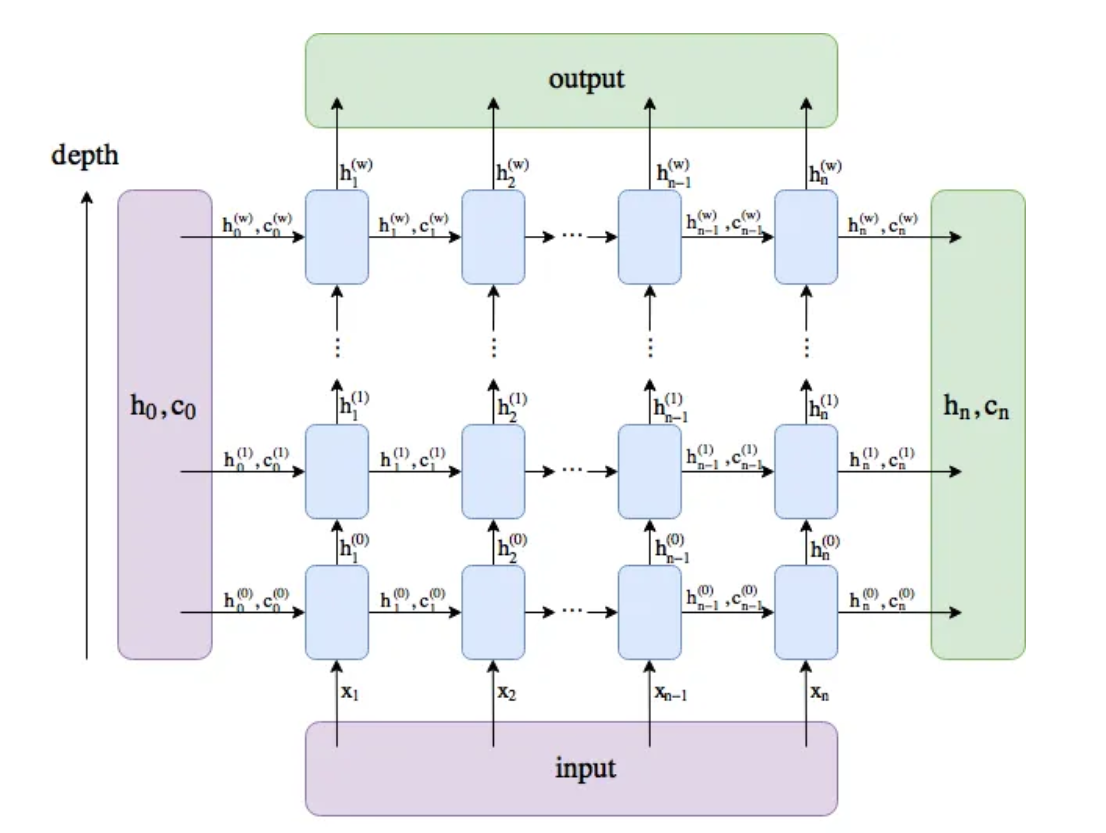

output in image is out and hn is hidden
`Sequence Length` is the length of sentence ie number of words

torch.nn.RNN has two outputs - `out` and `hidden`.

-`out(lastLayerAllTimeOutputs)` is the output of the RNN from all timesteps from the last RNN layer. It is of the size `(seq_len, batch, num_directions * hidden_size)`. If `batch_first=True`, the output size is `(batch, seq_len, num_directions * hidden_size)`. out[:,-1,:] means hidden state produced by last timestamp

-`hidden(LastTimeAllLayerOutputs)` is the hidden value from the last time-step of all RNN layers. It is of the size (num_layers * num_directions, batch, hidden_size). h_n is unaffected by batch_first=True.

hidden[-1,:,:] -->  hidden state produced by last layer

hidden[-1,:,:] and output[:,-1,:] are same

```
A batch --> many sentences (batch len) 
A sentence --> many words  (seq len)
A word --> tensor of embedding (input to rnn)


```

embeddings can be used as follows:

`vocab_size` it the size of vocabulary

`embedding_dim` is dimension of embeddings we want
```
*embedding expects an input sentence where each word is an integer 0 to vocab_size-1 eg sentence [1,4,2,0,4] where each number represents a unique word
self.embedding = nn.Embedding(vocab_size, embedding_dim)
*since each word now has dim = embedding_dim thus input size of rnn is embedding_dim
self.rnn = nn.RNN(embedding_dim, hidden_size,num_layers, batch_first=True)
```
## LSTM & GRU
They are implemented exactly same as rnn. There is only one difference in lstm i.e. the output given by lstm

out,hidden = nn.LSTM(input_size, hidden_size,num_layers, batch_first=True)

`hidden tensor`:It consists of two tensors: `hidden[0]` contains the final hidden state (h_n) and `hidden[1]` contains the final cell state (c_n) for all lstm layer and last timestamp 

In [272]:
model = MyRNN(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYER,OUTPUT_SIZE).to(device)

In [273]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
epochs = 100
best_loss = 1e9
patience = 5
count=0
losslst = []
vallst = []

In [278]:
for epoch in range(epochs):
    
    # Training
    model.train()  # telling model to go to training mode
    train_loss = 0
    train_count = 0
    train_pred = 0
    for data,label in train_dataloader:  #in each iteration data gets a batch from dataloader
        data,label = data.to(device),label.to(device)
        pred = model(data)
        loss = loss_func(pred,label)
        optimizer.zero_grad()  #clearing grad from prev batch
        loss.backward()  #calc grad
        optimizer.step() #update weights
        train_loss += loss.item()
        
        # pred.argmax(dim) -->gives index where the value is max accross col(if dim=0) or row(if dim=1)
        train_pred += (pred.argmax(1) == label).sum().type(torch.float).item()
        train_count += 1

    train_loss = train_loss / train_count   # mean loss over all batches
    

  # Validation
    if epoch%5==0:
        with torch.no_grad():
            model.eval()   # telling model to go to evaluation mode
            val_loss = 0
            val_count = 0
            val_pred = 0
            for data,label in val_dataloader:
                data,label = data.to(device),label.to(device)
                pred = model(data)
                loss = loss_func(pred,label)
                val_pred += (pred.argmax(1) == label).sum().type(torch.float).item()
                val_count += 1
                val_loss += loss.item()

            val_loss = val_loss / val_count
            vallst.append(val_loss)
            losslst.append(train_loss)
            if val_loss < best_loss:
                count = 0
                best_loss = val_loss
#                 checkpoint = {
#                     'epoch': epoch + 1,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'loss': best_loss,
#                 }
    #             torch.save(checkpoint, f"mcheckpoint:{epoch+1}")
    #             print(f"mcheckpoint:{epoch+1}")
            else:
                count += 1
            if count == patience:
                count=0
                print("Early Stopping !!!")
                break

            print(f"{epoch+1}: train_loss = {train_loss:.7f} | val_loss = {val_loss:.7f} " )


1: train_loss = 0.0004294 | val_loss = 0.0793984 
6: train_loss = 0.0003871 | val_loss = 0.0590718 
11: train_loss = 0.0003506 | val_loss = 0.0711222 
16: train_loss = 0.0003195 | val_loss = 0.0608620 
Early Stopping !!!


In [279]:
# Put model in evaluation mode
model.eval()

# Load your test dataset
# Assuming test_dataloader is defined elsewhere in your code and loaded with test data
test_dataloader = test_dataloader

# Initialize variables to monitor test performance
test_loss = 0
correct = 0

# No gradient updates needed for testing
with torch.no_grad():
    for data, label in test_dataloader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        loss = loss_func(pred, label)
        test_loss += loss.item()
        correct += (pred.argmax(1) == label).sum().item()

# Calculate average loss and accuracy over the test set
test_loss /= len(test_dataloader.dataset)
test_accuracy = 100. * correct / len(test_dataloader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.0005, Test Accuracy: 98.89%


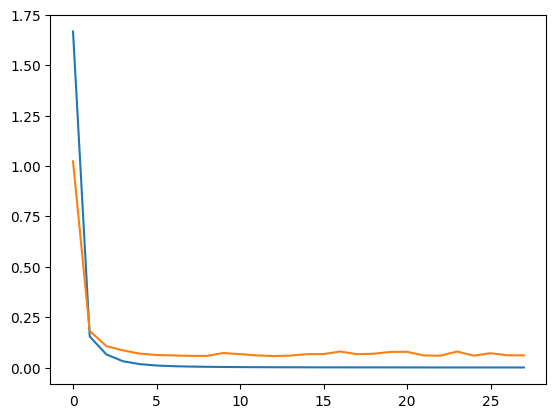

In [280]:
plt.plot(losslst)
plt.plot(vallst)
plt.show()